In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [2]:
device = torch.device('cpu')
if (torch.cuda.is_available()):
    device = torch.device('cuda')

## HYPERPARAMS

In [3]:
dataroot = '../storage/data/mnist_png/training/'
saveroot = '../storage/data/AS_storage/generatedImages/'
workers = 4
batch_size = 32
image_size = 784
label_dim = 10
nc = 1
nz = 100

num_epochs = 75
lr = 0.0001
momentum = 0.5
dampening = 0

k=1

## DATA

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=nc),
    torchvision.transforms.ToTensor(),
])

train_ds = torchvision.datasets.ImageFolder(dataroot, transforms)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=workers)
print('Length of dataset:',len(train_ds))

Length of dataset: 60000


Images shape: torch.Size([32, 1, 28, 28])
Labels: torch.Size([32]) Embedding: torch.Size([32, 10])


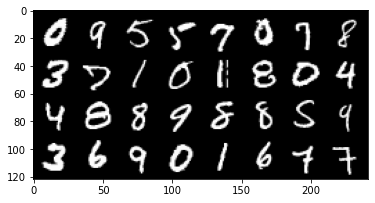

In [5]:
for images, labels in train_dl:
    print('Images shape:',images.shape)
    plt.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1,2,0))
    
    emb = nn.Embedding(label_dim, 10)
    emb_labels = emb(labels)
    print("Labels:", labels.shape, "Embedding:", emb_labels.shape)
    break

## MODELS

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.label_emb = nn.Embedding(label_dim, 10)
        
        self.fc1 = nn.Sequential(
            nn.Linear(nz+label_dim , 256),
            nn.LeakyReLU(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256 , 512),
            nn.LeakyReLU(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 1024),
            nn.LeakyReLU(0.2),
        )
        self.fc4 = nn.Sequential(
            nn.Linear(1024 , 784),
            nn.Tanh()
        )
        
    def forward(self, images, labels):
        #RECIEVES BATCH OF SIZE (batch_size, nz) and labels of size [batch_size]
        images = images.view(images.size(0), -1)
        labels = self.label_emb(labels)
        out = torch.cat((images, labels), dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_emb = nn.Embedding(label_dim, 10)
        
        self.fc1 = nn.Sequential(
            nn.Linear(784+label_dim , 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024 , 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512 , 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256 , 1),
            nn.Sigmoid()
        )
        
    def forward(self, images, labels):
        #RECIEVES BATCH OF SIZE (batch_size, 784) or (batch_size, 1, 28, 28) and labels of size [batch_size]
        images = images.view(images.size(0), -1)
        labels = self.label_emb(labels)
        out = torch.cat((images, labels), dim=1)        
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

## LOSS FUNCTIONS

In [9]:
opt_g = torch.optim.Adam(generator.parameters(), lr)
opt_d = torch.optim.Adam(discriminator.parameters(), lr)

criterion = nn.BCELoss()

## PRE-TRAIN FUNCTIONS

In [10]:
real_labels = torch.ones(batch_size,1).to(device)
fake_labels = torch.zeros(batch_size,1).to(device)

In [11]:
fixed_noise = torch.randn(25, nz).to(device)
fixed_labels = torch.LongTensor([0,0,0,0,0,0,1,2,3,0,0,4,5,6,0,0,7,8,9,0,0,0,0,0,0]).to(device)

## PRE-TRAIN TEST

In [12]:
sample = generator(fixed_noise, fixed_labels).detach()
print("Generated Samples:", sample.shape)

sample_output = discriminator(sample, fixed_labels).detach()
print("Sample Outputs:", sample_output.shape)

Generated Samples: torch.Size([25, 784])
Sample Outputs: torch.Size([25, 1])


## TRAIN

In [13]:
start_time = time.time()

loss_d = []
loss_g = []

for epoch in range(num_epochs):
    loss_d_ = 0.0
    loss_g_ = 0.0
    for i, (images, labels) in enumerate(train_dl):
        #DISCRIMINATOR
        opt_d.zero_grad()
        
        real_images = images.to(device)
        real_conditions = labels.to(device)
        fake_conditions = torch.randint(0,10,(batch_size,)).to(device)
        fake_images = generator(torch.randn(batch_size, nz).to(device), fake_conditions).detach()
        
        real_outputs = discriminator(real_images, real_conditions) 
        fake_outputs = discriminator(fake_images, fake_conditions) 
        
        real_loss = criterion(real_outputs, real_labels)
        fake_loss = criterion(fake_outputs, fake_labels)
        real_loss.backward()
        fake_loss.backward()
        
        opt_d.step()
        
        loss_d_ += real_loss + fake_loss
        
        #GENERATOR
        opt_g.zero_grad()
        
        fake_conditions = torch.randint(0,10,(batch_size,)).to(device)
        
        output = discriminator(
            generator(torch.randn(batch_size, nz).to(device), fake_conditions),
            fake_conditions
        )
        
        loss = criterion(output, real_labels)
        loss.backward()
        
        opt_g.step()
        
        loss_g_ += loss
    
    epoch_loss_g = loss_g_/i
    epoch_loss_d = loss_d_/i
    loss_g.append(epoch_loss_g)
    loss_d.append(epoch_loss_d)
    print(f'{epoch}/{num_epochs} | Generator_Loss: {epoch_loss_g:.8f} | Discriminator_Loss: {epoch_loss_d:.8f} | Time Elapsed: {time.time() - start_time:.0f} seconds')
    
    if epoch%1==0:
        sample = generator(fixed_noise, fixed_labels).detach()
        grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=5, pad_value=1, normalize=False)   
        torchvision.utils.save_image(grid.detach().cpu(), os.path.join(saveroot, 'MNIST_cGAN_{}.jpg'.format(str(epoch).zfill(3))))    
    
print(f'\nTOTAL DURATION: {time.time() - start_time:.0f} seconds')
sample = generator(fixed_noise, fixed_labels).detach()
grid = torchvision.utils.make_grid(sample.view(-1, 1, 28, 28), nrow=5, pad_value=1, normalize=False)   
torchvision.utils.save_image(grid.detach().cpu(), os.path.join(saveroot, 'MNIST_cGAN_075.jpg'))    

0/75 | Generator_Loss: 1.92643929 | Discriminator_Loss: 0.99836189 | Time Elapsed: 26 seconds
1/75 | Generator_Loss: 2.75446844 | Discriminator_Loss: 0.64831942 | Time Elapsed: 54 seconds
2/75 | Generator_Loss: 2.70438313 | Discriminator_Loss: 0.59220761 | Time Elapsed: 88 seconds
3/75 | Generator_Loss: 2.66940737 | Discriminator_Loss: 0.57577556 | Time Elapsed: 117 seconds
4/75 | Generator_Loss: 2.76317525 | Discriminator_Loss: 0.54175824 | Time Elapsed: 145 seconds
5/75 | Generator_Loss: 2.84827542 | Discriminator_Loss: 0.52172524 | Time Elapsed: 168 seconds
6/75 | Generator_Loss: 3.01599145 | Discriminator_Loss: 0.46173629 | Time Elapsed: 190 seconds
7/75 | Generator_Loss: 3.21560526 | Discriminator_Loss: 0.43317574 | Time Elapsed: 212 seconds
8/75 | Generator_Loss: 3.39019775 | Discriminator_Loss: 0.39728349 | Time Elapsed: 233 seconds
9/75 | Generator_Loss: 3.71684813 | Discriminator_Loss: 0.34941342 | Time Elapsed: 256 seconds
10/75 | Generator_Loss: 3.69346142 | Discriminator_Lo

## EVALUATION

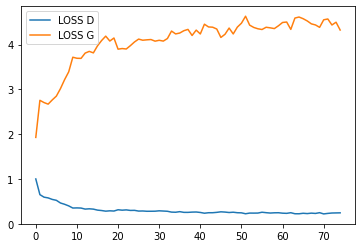

In [14]:
plt.figure()

plt.plot(loss_d, label='LOSS D')
plt.plot(loss_g, label='LOSS G')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


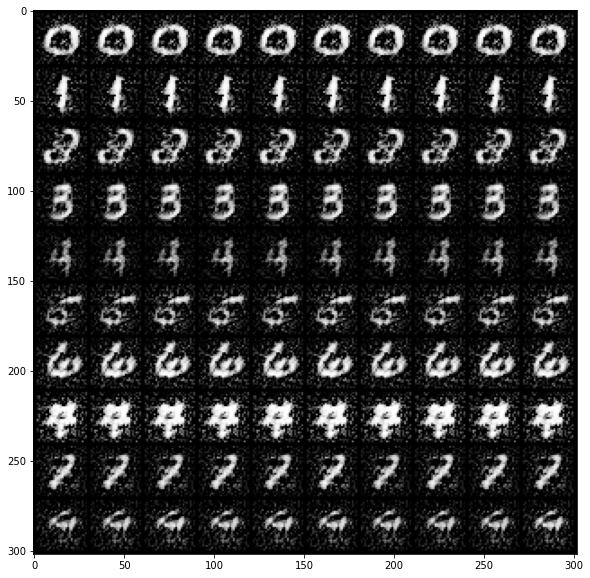

In [15]:
z = torch.randn(100, nz).to(device)
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(device)
images = generator(z, labels).detach()
grid = torchvision.utils.make_grid(images.view(-1,1, 28,28), nrow=10, normalize=False)
plt.figure(figsize=(10,10))
plt.imshow(grid.detach().cpu().permute(1,2,0))

## SAVING

In [16]:
torch.save(generator.state_dict(), './mnist_cgan_generator.pt')
torch.save(discriminator.state_dict(), './mnist_cgan_discriminator.pt')

In [17]:
# # LOAD MODEL
# discriminator.load_state_dict(torch.load('./mnist_vanilla_gan_discriminator.pt'))
# generator.load_state_dict(torch.load('./mnist_vanilla_gan_generator.pt'))